# Molecule Ring-Based Lifting Tutorial

***
This notebook imports QM9 dataset and applies a lifting to the molecular representation based on molecular ring information. Then, a neural network is run using the loaded data.

As proposed by [Jin et al. (2018)](https://arxiv.org/abs/1802.04364), this implementation aims to condense a molecule ring into a single element. Utilizing the [QM9 dataset](https://paperswithcode.com/dataset/qm9), a benchmark dataset for molecule prediction, we develop a method to treat rings as 2-cell structures by identifying them through the provided SMILES representations of each molecule.

Additionally, attributes inspired by those used in [(Battiloro et al., 2024)](https://arxiv.org/abs/2405.15429) are incorporated into the elements, enhancing the representation of the molecule.
The attributes are:
- **Node**: Atom type, atomic number, and chirality.
- **Edge**: Bond type, conjugation and stereochemistry.
- **Rings**: Ring size, aromaticity, heteroatoms, saturation, hydrophobicity, electrophilicity, nucleophilicity, and polarity.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the loading QM9 dataset and a ring-based tranformation, creates a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
* QM9

With this implementation, also **QM9** is available.
***

### Imports and utilities

In [2]:
import sys
import os

# add ../../ so I can read other modules
sys.path.append("../../")



In [3]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the dataset

Here we just need to specify the name of the available dataset that we want to load, in this case, QM9 dataset. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [4]:
dataset_name = "UniProt"
dataset_config = load_dataset_config(dataset_name)
loader = PointCloudLoader(dataset_config)


Dataset configuration for UniProt:

{'data_domain': 'pointcloud',
 'data_type': 'UniProt',
 'data_name': 'UniProt',
 'data_dir': 'datasets/pointcloud/UniProt',
 'query': 'length:[95 TO 155]',
 'format': 'tsv',
 'fields': 'accession,length',
 'size': 500,
 'limit': 10,
 'threshold': 6.0,
 'num_features': 11,
 'num_classes': 1,
 'task': 'regression',
 'loss_type': 'mse',
 'monitor_metric': 'mae',
 'task_level': 'graph'}


We can then access to the data through the `load()`method. 

Observe that some data points emit warnings, which are due to the fact that the SMILES representation of the molecule is not valid. This is a known issue with the QM9 dataset, and it is not a problem for this tutorial. When loading the dataset, the loader will skip these data points, so they keep excluded for the lifting process.

In [7]:
dataset = loader.load()
# describe_data(dataset)

PDB file for P61970 already exists.
PDB file for P59103 already exists.
PDB file for Q7Z2G1 already exists.
PDB file for O00175 already exists.
PDB file for P01848 already exists.
PDB file for P02042 already exists.
PDB file for P01762 already exists.
PDB file for P25815 already exists.
PDB file for P60328 already exists.
PDB file for P05386 already exists.
PDB file for P61970 already exists.
PDB file for P59103 already exists.
PDB file for Q7Z2G1 already exists.
PDB file for O00175 already exists.
PDB file for P01848 already exists.
PDB file for P02042 already exists.
PDB file for P01762 already exists.
PDB file for P25815 already exists.
PDB file for P60328 already exists.
PDB file for P05386 already exists.


## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. 

A **ring-based lifting** is applied. Molecule ring information is extracted for each molecule. Then, a 2-cell is assigned to each ring.


In [ ]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2combinatorial"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2cell/ring_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CellRingLifting',
 'max_cell_length': None,
 'preserve_edge_attr': True,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

In [ ]:
# Option to do it with a part of the dataset, took too long to run the whole dataset
dataset = dataset[100:1000]

Transform parameters are the same, using existing data_dir: /home/bmiquel/Documents/Projects/Topo/challenge-icml-2024/datasets/graph/QM9/QM9/lifting/3908446618

Dataset contains 900 samples.

Providing more details about sample 0/900:


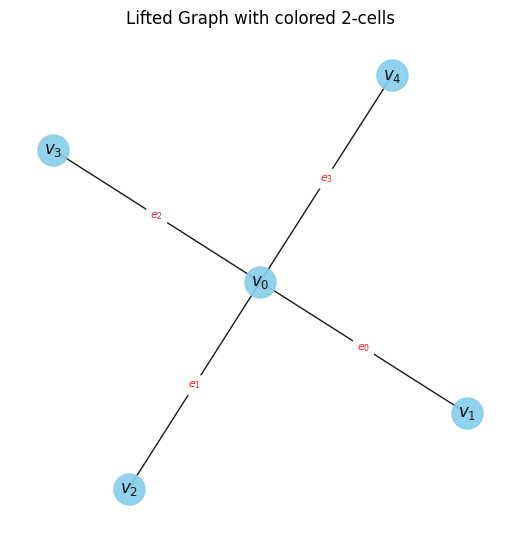

 - Graph with 5 vertices and 4 edges.
 - Features dimensions: [11, 11]
 - There are 0 isolated nodes.



In [ ]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Cell NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `x_0`, `x_1`, `x_2` which are the features of the nodes, edges and cells respectively. 

In QM9 dataset, there are 11 different features. That has been modified in the *dataset_config* file updating the correct number of features.

It also uses the `adjacency_1`, `incidence_1` and `incidence_2` matrices so the lifting should make sure to add them to the data.

In [ ]:
from modules.models.cell.cwn import CWNModel

model_type = "cell"
model_id = "cwn"
model_config = load_model_config(model_type, model_id)

model = CWNModel(model_config, dataset_config)


Model configuration for cell CWN:

{'in_channels_0': None,
 'in_channels_1': None,
 'in_channels_2': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [ ]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 